# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет.

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/data_science/datasets/"

Mounted at /content/drive


In [3]:
df = pd.read_csv(way + 'persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [4]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

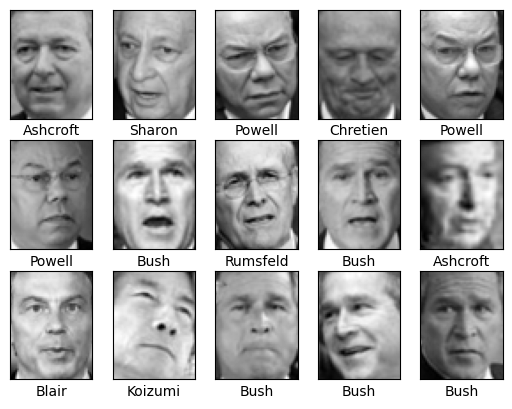

In [5]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Крупнее

(-0.5, 46.5, 61.5, -0.5)

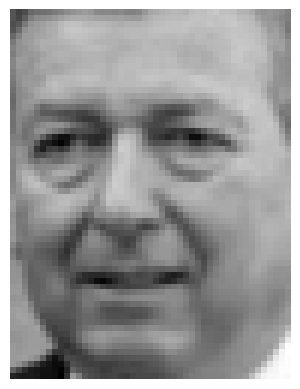

In [6]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [7]:
df['label'].nunique()

12

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса.

In [8]:
unique_lbl = df['label'].unique()

In [9]:
n_lbl = df.shape[0]
df_share = pd.DataFrame(columns = ['label', 'prop'])
for lab in df['label'].unique():
    prop_lab = df[df['label'] == lab].shape[0] / n_lbl
    new_row = pd.DataFrame({'label': [lab], 'prop': [prop_lab]})
    df_share = pd.concat([df_share, new_row], ignore_index=True)
df_share


,label,prop
0,John Ashcroft,0.033937
1,Ariel Sharon,0.049020
2,Colin Powell,0.151584
3,Jean Chretien,0.035445
4,George W Bush,0.340121
5,Donald Rumsfeld,0.077677
6,Tony Blair,0.092006
7,Junichiro Koizumi,0.038462
8,Gerhard Schroeder,0.070136
9,Hugo Chavez,0.045249


На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [10]:
mean_lab = df.groupby('label').mean().reset_index()
mean_lab.head(1)

,label,0,1,2,3,4,5,6,7,8,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,Ariel Sharon,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.58182,0.591835,0.604465,...,0.3964,0.433947,0.478291,0.51992,0.532549,0.515656,0.49822,0.486657,0.466928,0.437687


Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [11]:
mean_shr = mean_lab.loc[mean_lab['label'] == 'Gerhard Schroeder']
mean_shr

,label,0,1,2,3,4,5,6,7,8,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
4,Gerhard Schroeder,0.210162,0.22821,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,...,0.414969,0.430937,0.469281,0.494596,0.496718,0.48255,0.442252,0.428477,0.426875,0.411118


Используя усредненные векторы, постройте изображения всех людей из набора данных.

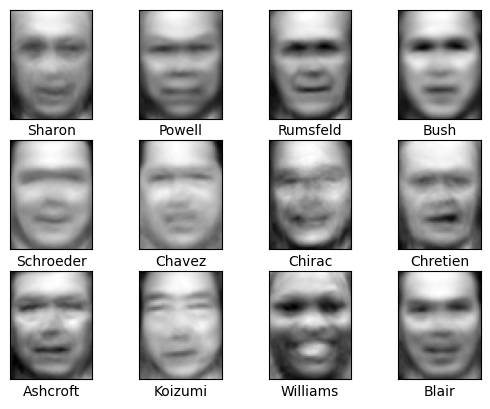

In [12]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(mean_lab.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('mean_persone.png', dpi = 300, bbox_inches='tight')

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [13]:
from scipy.spatial.distance import cosine
import plotly.graph_objects as go

cosine_similarity_matrix = np.zeros((len(unique_lbl), len(unique_lbl)))

for i, label1 in enumerate(unique_lbl):
    for j, label2 in enumerate(unique_lbl):
        vec1 = mean_lab.loc[mean_lab['label'] == label1].drop('label', axis = 1).squeeze(axis = 0)
        vec2 = mean_lab.loc[mean_lab['label'] == label2].drop('label', axis = 1).squeeze(axis = 0)
        cosine_similarity_matrix[i, j] = 1 - cosine(vec1, vec2)
        #print(vec1)

cosine_similarity_df = pd.DataFrame(cosine_similarity_matrix, index=unique_lbl, columns=unique_lbl)

fig = go.Figure(data=go.Heatmap(
    z=cosine_similarity_matrix,
    x=unique_lbl,
    y=unique_lbl))

fig.show()

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [14]:
0.987

0.987

# Построение модели

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import time

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('label', axis=1),
    df['label'],
    test_size=0.2,
    random_state=5,
    stratify=df['label']
)

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [ ]:
svc = SVC(kernel='linear', random_state=5)
svc.fit(x_train, y_train)

SVC(kernel='linear', random_state=5)

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
y_pred = svc.predict(x_test)
accuracy = f1_score(y_test, y_pred, average = 'weighted')
accuracy

0.7408103886614767

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [ ]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[5]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [ ]:
start_time = time.time()

cv.fit(x_train, y_train)

print("Время обучения: %s секунд" % (time.time() - start_time))

print("Наилучшие параметры: ", cv.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.778 total time=   3.7s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   2.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.825 total time=   1.5s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.802 total time=   1.2s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.769 total time=   1.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.377 total time=   1.5s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.358 total time=   1.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.373 total time=   1.7s
[CV 4/5] END C=1, class_weight=None, gam

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [ ]:
svc_best = SVC(kernel='sigmoid', C = 1000, gamma = 0.0001, class_weight = 'balanced', random_state=5)

In [ ]:
svc_best.fit(x_train, y_train)
y_pred = svc_best.predict(x_test)
accuracy = f1_score(y_test, y_pred, average = 'weighted')
accuracy

0.770802678845364

## Уменьшение размерности

In [ ]:
from sklearn.decomposition import PCA

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [ ]:
pca = PCA(svd_solver='full')
pca.fit(x_train)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f"Минимальное количество компонент для объясненной дисперсии 0.95: {n_components}")


Минимальное количество компонент для объясненной дисперсии 0.95: 173


Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [ ]:
pca_cor = PCA(n_components=n_components, svd_solver='full')
pca_cor.fit(x_train)

PCA(n_components=173, svd_solver='full')

In [ ]:
x_train_pca = pca_cor.transform(x_train)
x_test_pca = pca_cor.transform(x_test)

In [ ]:
x_train_pca.shape

(1060, 173)

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [ ]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[5]}]


cv_pca = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

In [ ]:
start_time = time.time()

cv_pca.fit(x_train_pca, y_train)

print("Время обучения: %s секунд" % (time.time() - start_time))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.2s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.750 total time=   0.2s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.811 total time=   0.2s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   0.2s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.2s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.344 total time=   0.2s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.2s
[CV 4/5] END C=1, class_weight=None, gam

Определите гиперпараметры лучшей полученной модели.

In [ ]:
print("Наилучшие параметры: ", cv_pca.best_params_)

Наилучшие параметры:  {'C': 1000, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf', 'random_state': 5}


Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
svc_best_pca = SVC(kernel='rbf', C = 1000, gamma = 0.0001, class_weight = 'balanced', random_state=5)

In [ ]:
svc_best_pca.fit(x_train_pca, y_train)
y_pred = svc_best_pca.predict(x_test_pca)
accuracy = f1_score(y_test, y_pred, average = 'weighted')
accuracy

0.754762104839105

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.

# Задание 2

In [19]:
x_train_2 = df.drop('label', axis = 1)

In [20]:
y_train_2 = df['label']

In [21]:
x_train_2.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
349,0.533333,0.616993,0.739869,0.796078,0.870588,0.954248,0.930719,0.837908,0.794771,0.784314,...,0.988235,0.988235,0.976471,0.967320,0.824837,0.401307,0.158170,0.185621,0.211765,0.227451
6,0.392157,0.525490,0.588235,0.590850,0.589542,0.598693,0.606536,0.615686,0.631373,0.653595,...,0.371242,0.360784,0.427451,0.385621,0.368627,0.522876,0.716340,0.781699,0.441830,0.150327
280,0.194771,0.362092,0.457516,0.466667,0.483660,0.482353,0.492810,0.498039,0.488889,0.486274,...,0.155556,0.142484,0.098039,0.101961,0.315033,0.511111,0.529412,0.509804,0.487582,0.471895
758,0.318954,0.325490,0.266667,0.190850,0.235294,0.367320,0.456209,0.467974,0.479739,0.477124,...,0.133333,0.134641,0.124183,0.120261,0.129412,0.134641,0.167320,0.164706,0.176471,0.224837
1152,0.111111,0.087582,0.074510,0.060131,0.062745,0.067974,0.077124,0.084967,0.105882,0.111111,...,0.239216,0.294118,0.350327,0.386928,0.385621,0.380392,0.431373,0.516340,0.597386,0.613072


In [25]:
test_2 = pd.read_csv(way + 'persons_pics_reserved.csv')

In [26]:
test_2.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
46,0.147712,0.194771,0.196078,0.201307,0.313725,0.350327,0.342484,0.360784,0.372549,0.405229,...,0.920261,0.971242,0.971242,0.985621,0.960784,0.934641,0.865359,0.433987,0.147712,0.133333
163,0.406536,0.402614,0.403922,0.416993,0.430065,0.407843,0.367320,0.372549,0.430065,0.504575,...,0.614379,0.627451,0.600000,0.610458,0.627451,0.613072,0.618301,0.628758,0.630065,0.639216
133,0.145098,0.245752,0.422222,0.556863,0.597386,0.588235,0.588235,0.592157,0.581699,0.585621,...,0.332026,0.346405,0.389543,0.407843,0.320261,0.308497,0.308497,0.307190,0.296732,0.282353
57,0.445752,0.456209,0.405229,0.462745,0.426144,0.413072,0.538562,0.569935,0.596078,0.626144,...,0.405229,0.393464,0.384314,0.373856,0.371242,0.351634,0.354248,0.372549,0.379085,0.431373
0,0.315033,0.393464,0.517647,0.636601,0.652288,0.653595,0.677124,0.725490,0.716340,0.695425,...,0.031373,0.047059,0.047059,0.053595,0.050980,0.036601,0.027451,0.011765,0.007843,0.003922


In [42]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [36]:
pca = PCA(svd_solver='full')
pca.fit(x_train_2)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(cumulative_explained_variance >= 0.98)[0][0] + 1

print(f"Минимальное количество компонент для объясненной дисперсии 0.95: {n_components}")


Минимальное количество компонент для объясненной дисперсии 0.95: 331


In [37]:
pca_cor = PCA(n_components=n_components, svd_solver='full')
pca_cor.fit(x_train_2)

PCA(n_components=331, svd_solver='full')

In [44]:
x_train_2_pca = pca_cor.transform(x_train_2)
x_test_2_pca = pca_cor.transform(test_2)

In [43]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[5]}]


cv_2_pca = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

In [46]:
cv_2_pca.fit(x_train_2_pca, y_train_2)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.801 total time=   0.4s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.792 total time=   0.3s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.800 total time=   0.5s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.789 total time=   0.5s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.781 total time=   0.4s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.338 total time=   0.4s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.4s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [5]}],
             verbose=3)

In [47]:
print("Наилучшие параметры: ", cv_2_pca.best_params_)

Наилучшие параметры:  {'C': 100, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 5}


In [48]:
svc_2_pca = SVC(kernel='rbf', C = 100, gamma = 0.0001, random_state=5)

In [49]:
svc_2_pca.fit(x_train_2_pca, y_train_2)
y_pred = svc_2_pca.predict(x_test_2_pca)
y_pred

array(['George W Bush', 'Ariel Sharon', 'Gerhard Schroeder',
       'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld',
       'Colin Powell', 'Tony Blair', 'Gerhard Schroeder', 'George W Bush',
       'Hugo Chavez', 'George W Bush', 'Hugo Chavez', 'Colin Powell',
       'George W Bush', 'Ariel Sharon', 'Colin Powell', 'George W Bush',
       'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush',
       'Colin Powell', 'George W Bush', 'George W Bush',
       'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair',
       'Serena Williams', 'Jean Chretien', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'George W Bush',
       'Gerhard Schroeder', 'Colin Powell', 'Donald Rumsfeld',
       'George W Bush', 'George W Bush', 'Tony Blair', 'George W Bush',
       'George W Bush', 'Tony Blair', 'Colin Powell', 'Tony Blair',
       'Serena Williams', 'Jean Chretien', 'Tony Blair', 